# Analysis of tblCardData

This notebook contains codes and functions to run queries to analyze and understand the data present in the table `tblCardData` of the xspoc database.

In [1]:
"""
For setting up local imports in an Ipython Shell
This is a workaround for ipython, dont need it for basic python scripts
"""
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import struct
import matplotlib.pyplot as plt

# Project Library
from library.dbconnection import PostgresRDS
from library.sqlFunctions import run_query

In [28]:
"""
Dyna Functions
Note: Once Testing done will be moved to the library
"""

def get_dyna(card_arr):
    """
    Transforms Hexadecimal Dyna Card Value into Position and Load value
    Logic for oasis dyna cards
    :param card_arr: Hexadecimal Array
    :return: Position, Load 2D array
    """
    if pd.isnull(card_arr):
        pos = [0, 0, 0]
        load = [0, 0, 0]

    else:
#         test_card = card_arr[2:].strip()  # only modification from bonanza
        test_card = card_arr
        display(len(test_card))
        mid = len(test_card) / 2
        mid = int(mid)

        load = []
        pos = []

        for i in range(0, mid, 8):
            load_temp = test_card[i:i + 8]
            load_int = struct.unpack('f', bytes.fromhex(load_temp))[0]
            load.append(load_int)

            pos_temp = test_card[mid + i:mid + i + 8]
            pos_int = struct.unpack('f', bytes.fromhex(pos_temp))[0]
            pos.append(pos_int)

    return np.column_stack(([pos, load]))


def dyna_plot(card, name, fill=True, color='k', set_axis=None, save=None, show=True):
    xy = get_dyna(card)
    pos_clean = xy[:, 0] 
    load_clean = xy[:, 1]

    fig_clean, ax_clean = plt.subplots()

    if fill:
        ax_clean.fill(pos_clean, load_clean, facecolor=color, alpha=1)
    else:
        ax_clean.plot(pos_clean, load_clean, c=color, alpha=1)

    if set_axis:
        ax_clean.set_ylim(set_axis)

#     plt.axis('off')
    fig_clean.set_size_inches(12, 8)

    if show:
        plt.show()

    if save:
        save_name = os.path.join(save, name + ".png")
        plt.savefig(save_name, dpi=50, bbox_inches='tight')

    plt.close()

## Queries

Uee the `run_query` functions to run queries. Check `Analysis.md` for some examples.

In [15]:
%%time
# Some Exploratory Queries

cols_query = """
SELECT attname            AS col
     , atttypid::regtype  AS datatype
       -- more attributes?
FROM   pg_attribute
WHERE  attrelid = 'xspoc_dbo."tblCardData"'::regclass  -- table name, optionally schema-qualified
AND    attnum > 0
AND    NOT attisdropped
ORDER  BY attnum;
"""

well_query = """
SELECT DISTINCT("NodeID")
FROM xspoc_dbo."tblCardData"
ORDER BY "NodeID"
"""

with PostgresRDS() as engine:
    col_list = run_query(cols_query, engine)  # Profiling: 1s 680ms -- Will be longer in jupyter
    well_list = run_query(well_query, engine)  # Profiling: 1m 10s -- Longer in jupyter

Connected to oasis-data DataBase
Connection Closed
Wall time: 1min 37s


In [18]:
print("List of Columns")
display(col_list)

print('\n list of wells')
display(well_list)

List of Columns


,col,datatype
0,NodeID,character varying
1,Date,timestamp without time zone
2,CardType,character varying
3,SurfaceCard,text
4,SPM,real
5,StrokeLength,integer
6,Runtime,real
7,LoadLimit,integer
8,PositionLimit,integer
9,DownholeCard,text



 list of wells


,NodeID
0,Aagvik 1-35H
1,ACADIA 31-25H
2,Acklins 12-18H
3,Aerabelle 5502 43-7T
4,A. JOHNSON 12-1H
...,...
900,YEISER 5603 42-33H
901,Yukon 41-12T
902,Zaye Federal 34-2H
903,Zdenek 6093 42-24H


## Well Specific

In [20]:
query = """
SELECT 
"NodeID",
"Date",
encode("tblCardData"."DownholeCardB", 'hex') as downcard,
encode("tblCardData"."SurfaceCardB", 'hex') as surfcard,  -- Add more column if need be
"Area",
"LoadLimit"
FROM xspoc_dbo."tblCardData"
WHERE "NodeID" = 'Yukon 41-12T'
ORDER BY "NodeID" , "Date";
"""

with PostgresRDS() as engine:
    well_data = run_query(query, engine)
    
display(well_data.head())

Connected to oasis-data DataBase
Connection Closed


3200

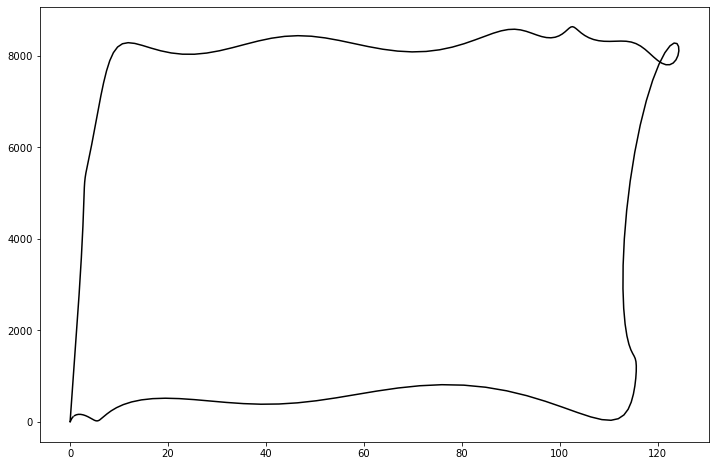

In [31]:
test_card = well_data.loc[2200, 'downcard']

# Plotting
dyna_plot(test_card, name='Test' , fill=False, color='k', set_axis=None, save=None, show=True)

## Query a list of wells

In [32]:
%%time
# Add wells to the list
well_list = [
    'ACADIA 31-25H',
    'Zutz 44-12T',
    'A. JOHNSON 12-1H'
]

query = """
select 
"NodeID",
"Date",
encode("tblCardData"."DownholeCardB", 'hex') as downcard, 
"CardArea",
"StrokeLength"               -- Add or delete columns
from xspoc_dbo."tblCardData"
where "NodeID" in {}
order by "NodeID", "Date"
""".format(tuple(well_list))

with PostgresRDS() as engine:
    data = run_query(query, engine)

display(data.head())

Connected to oasis-data DataBase
Connection Closed
Wall time: 39.2 s


array(['ACADIA 31-25H', 'A. JOHNSON 12-1H', 'Zutz 44-12T'], dtype=object)